## Imports and settings

In [1]:
import src
import keras.backend as K
import os
import numpy as np
import sys
import re
import math
import io
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from  matplotlib.animation import FuncAnimation
from matplotlib import colors
from netCDF4 import Dataset
from IPython.display import clear_output
#data folder
sys.path.insert(0, 'C:/Users/pkicsiny/Desktop/TUM/3/ADL4CV/data')
#forces CPU usage
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0" #"" or "-1" for CPU, "0" for GPU
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2699092632091320220
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1508248780
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7674266168578603934
physical_device_desc: "device: 0, name: GeForce GT 740M, pci bus id: 0000:01:00.0, compute capability: 3.5"
]


### GAN

In [34]:
#modified from source: https://github.com/eriklindernoren/Keras-GAN/blob/master/gan/gan.py
class GAN():
    def __init__(self, dual=False, past=1, loss_function="l1",
                 augment=False, g_dropout=0.5, d_dropout=0.5, batchnorm=True, obj=1, bce_s=0, bce_t=0):
        self.dual = dual #set this to True to train temporal discriminator
        self.size = 64
        self.g_dropout = g_dropout
        self.d_dropout = d_dropout
        self.past_input = past #set this to change sequence length
        self.input_shape = (self.size, self.size, self.past_input) # 64, 64, t
        self.log = {"g_loss":[],
               "d_loss":[],
               "g_metric":[],
               "d_metric":[]}
        self.gradients = {"g_grads":[],
                         "ds_grads":[],
                         "dt_grads":[]}
        self.inputs = []
        self.outputs = []
        self.train_data = None
        self.xval_data = None
        self.test_data = None
        self.augment = augment
        self.batchnorm = batchnorm
        #Loss params      
        self.loss_weights = [obj, bce_s]
        self.losses = [src.custom_loss(loss=loss_function), keras.losses.binary_crossentropy]
        self.d_metric = [keras.metrics.binary_accuracy]
        
        self.d_optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        #0.01
        self.g_optimizer = keras.optimizers.Adam(0.0002, 0.5, decay=1e-6)
        #lr=0.0002, 0.5

        
# Build the generator
        self.generator = self.build_generator()
        # The generator takes a sequence of frames as input and generates the next image in that sequence
        input_img = keras.layers.Input(shape=self.input_shape)
        self.inputs.append(input_img)
        generated = self.generator(input_img)
        self.outputs.append(generated)
        
# Build and compile spatial discriminator
        self.s_discriminator = self.build_discriminator("s")
        self.s_discriminator.compile(loss='binary_crossentropy',
            optimizer=self.d_optimizer,
            metrics=self.d_metric)
        # Spatial disc. takes the x as condition and G(x) and returns a float
        score_s = self.s_discriminator([input_img, generated])
        self.outputs.append(score_s)
        self.s_discriminator.trainable = False
        
# Build and compile temporal discriminator (same as s disc. but has different inputs
        if self.dual:
            self.t_discriminator = self.build_discriminator("t")
            self.t_discriminator.compile(loss='binary_crossentropy',
                optimizer=self.d_optimizer,
                metrics=self.d_metric)
            #Temporal disc. takes in advected frame A(G(x_previous)) and G(x)
            adv = keras.layers.Input(shape=self.input_shape)
            self.inputs.append(adv)
            score_t = self.t_discriminator([adv, generated])
            self.outputs.append(score_t)
            self.t_discriminator.trainable = False  
            self.losses.append(keras.losses.binary_crossentropy)
            self.loss_weights.append(bce_t)
        
#Combined GAN model
        self.combined = keras.models.Model(inputs=self.inputs, outputs=self.outputs)
        #loss on all ouputs as a list: l1 loss on generated img, cross entropy for discriminator
        self.combined.compile(loss=self.losses, optimizer=self.g_optimizer, loss_weights=self.loss_weights)

    def build_generator(self,network="U-net"):  
        generator = keras.Sequential()
        if network in ["Unet", "U-net", "unet", "u-net"]:
            return src.unet(self.input_shape,dropout=self.g_dropout, batchnorm=self.batchnorm)  # 64, 64, t

    def build_discriminator(self, which="s"):
        if which == "s":
            return src.spatial_discriminator(condition_shape=self.input_shape, dropout=self.d_dropout)
        elif which == "t":
            return src.temporal_discriminator()
# ---------------------
#  Train
# ---------------------
    def train(self, epochs, d_epochs=1, dataset="5min", batch_size=64, overfit=False):
        assert isinstance(d_epochs, int) > 0 and isinstance(epochs, int) > 0 , "Number of epochs must be a positive integer."
        
# Load the dataset
        if self.dual:
            if dataset not in ["gan", "GAN", "tempogan", "tempoGAN"]:
                dataset = "gan"
                print("tempoGAN training: Changed dataset to GAN data.")
            self.past_input += 1
            print("tempoGAN training: Increased input sequence length by one. First frame is only auxiliary for advection.")
        else:
            if dataset in ["gan", "GAN", "tempogan", "tempoGAN"]:
                dataset = "5min"
                print("Normal GAN training: Changed dataset to 5min data.")
        
        if overfit:
            batch_size = 1
            print("Overfit test: batch size set to 1.")

            
        print(f"Loading {dataset} dataset.")
        self.train_data, self.xval_data, self.test_data = src.load_datasets(dataset, self.past_input)
        self.train_data[np.isnan(self.train_data)] = 0
        self.xval_data[np.isnan(self.xval_data)] = 0
        self.test_data[np.isnan(self.test_data)] = 0
# split the dataset to inputs and ground truths
        gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(
            self.train_data, self.xval_data, self.test_data, past_frames=self.past_input, augment=self.augment)
        
        
        if overfit:
            batch_size = 1
            gan_train = gan_train[0:1]
            gan_truth = gan_truth[0:1]
            print("Overfit test: batch size set to 1.")
            
# Adversarial ground truths
        real = np.ones((batch_size, 1))#*0.9
        fake = np.zeros((batch_size, 1))
#Generator ground truths
        g_real = np.ones((batch_size, 1))
        print(f"Initial loss weights: {self.loss_weights}")
        for epoch in range(epochs):
            
# update loss weights
           # if epoch in [20, 50, 90, 140, 200]:
           #     self.update_loss_weights()
# ---------------------
#  Train Discriminators
# ---------------------

# Train the first discriminator
#inputs: [frame t, generated frame t+1 (from frame t)] & [frame t, ground truth of frame t (frame t+1)]
#batches are unmixed
            self.s_discriminator.trainable = True
            for ks in range(d_epochs):
                # all 4D
                real_imgs, training_batch, generated_imgs, _, _ = self.create_training_batch(gan_train, gan_truth, batch_size)
                #mix 5% of labels
                d_real, d_fake = self.noisy_d_labels(real, fake)
                ds_loss_real = self.s_discriminator.train_on_batch([training_batch, real_imgs], d_real)
                ds_loss_fake = self.s_discriminator.train_on_batch([training_batch, generated_imgs], d_fake)
                ds_loss = 0.5 * np.add(ds_loss_real, ds_loss_fake)
                if d_epochs > 1:
                    print(f"    {ks} [Ds loss: {ds_loss[0]}, acc.: {100*ds_loss[1]}]")
            true_xval = self.s_discriminator.predict([gan_val[:batch_size], gan_val_truth[:batch_size]])
            fake_xval = self.generator.predict(gan_val[:batch_size])
            fake_xval = self.s_discriminator.predict([gan_val[:batch_size], fake_xval])
            d_loss = ds_loss
            self.s_discriminator.trainable = False
                
# Train the second discriminator
#inputs: [advected generated frame t (from frame t-1), generated frame t+1 (from frame t)] &
#        [advected ground truth of frame t-1 (advected frame t), ground truth frame t (frame t+1)]
#batches are unmixed
            if self.dual:
                self.t_discriminator.trainable = True
                for kt in range(d_epochs):
                    real_imgs, training_batch, generated_imgs, advected_aux_gen, advected_aux_truth = self.create_training_batch(
                                                                                        gan_train, gan_truth, batch_size)
                    #only need rain map from the synthetics
                    d_real, d_fake = self.noisy_d_labels(real, fake)
                    dt_loss_real = self.t_discriminator.train_on_batch([advected_aux_truth, real_imgs], d_real)
                    dt_loss_fake = self.t_discriminator.train_on_batch([advected_aux_gen, generated_imgs], d_fake)
                    dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
                    #self.gradients["dt_grads"].append(self.get_gradients(self.t_discriminator))
                    if d_epochs > 1:
                        print(f"    {kt} [Dt loss: {dt_loss[0]}, acc.: {100*dt_loss[1]}]")
                d_loss = ds_loss + dt_loss
                self.t_discriminator.trainable = False
            
# ---------------------
#  Train Generator
# ---------------------

            idx = np.random.randint(0, gan_train.shape[0], batch_size)
            if self.dual:
                training_truth = gan_truth[idx]  # frame t+1, 4D: n, 64, 64, 1
                assert training_truth.shape[-1] == 1, f"real_imgs: (n, 64, 64, 1), {real_imgs.shape}"
                aux_batch = gan_train[idx,:,:,:-1]  # from 0 to frame t-1 (not the last frame) 4D: n, 64, 64, past-1
                assert aux_batch.shape[-1] == self.past_input-1, f"aux_batch: (n, 64, 64, {self.past_input-1}), {aux_batch.shape}"
                training_batch = gan_train[idx,:,:,1:]  # from frame 1 to frame t, 4D: n, 64, 64, past-1
                assert training_batch.shape[-1] == self.past_input-1, f"training_batch: (n, 64, 64, {self.past_input-1}), {training_batch.shape}"
                aux_gen_imgs = self.generator.predict(aux_batch) # 4D, n, 64, 64, 1: output is frame t  
                assert aux_gen_imgs.shape[-1] == 1, f"aux_gen_imgs: (n, 64, 64, 1), {aux_gen_imgs.shape}"
                # calculate optical flow for frame t-1 -> t
                vx, vy = src.optical_flow(aux_batch[:,:,:,-1:], training_batch[:,:,:,-1:], window_size=4, tau=1e-2)
                assert vx.shape[-1] == 1, f"vx, vy: (n, 64, 64, 1), {vx.shape}"
                # concat channels
                aux_gen_imgs = np.concatenate((aux_gen_imgs, vx, vy), axis=-1) #n, 64, 64, 3
                assert aux_gen_imgs.shape[-1] == 3, f"aux_gen_imgs: (n, 64, 64, 3), {aux_gen_imgs.shape}"
                # advect generated frame t
                advected_aux_gen = np.array([src.advect(sample) for sample in aux_gen_imgs]) #4D (n, 64, 64, 1)
                assert advected_aux_gen.shape[-1] == 1, f"advected_aux_gen: (n, 64, 64, 1), {advected_aux_gen.shape}"
            else:
                training_batch = gan_train[idx]  # frame t or all past frames, 4D
                training_truth = gan_truth[idx]  # frame t+1 or all future frames, 4D

# Train the generator (to have the discriminator label samples as real)
            if self.dual:
                g_loss = self.combined.train_on_batch([training_batch, advected_aux_gen], [training_truth, g_real, g_real])
            else:
                g_loss = self.combined.train_on_batch(training_batch, [training_truth, g_real])

# Plot the progress
            self.log["g_loss"].append(g_loss)
            self.log["d_loss"].append(d_loss[0])
            #self.log["g_metric"].append(g_loss[1])
            self.log["d_metric"].append(d_loss[1])
            print(f"\033[1m {epoch}\n[D loss: {d_loss[0]}, acc.: {100*d_loss[1]}, xval fake.: {np.mean(fake_xval)}, "+
                  f"xval true: {np.mean(true_xval)}]\033[0m\n"+
                  f"\033[1m[G loss: {np.round(g_loss[0], 4)}, obj.: {np.round(g_loss[1], 4)},"+
                  f"bce.: {np.round(g_loss[2], 4)}]\033[0m")
           # self.gradients["g_grads"].append(self.get_gradients(self.combined))


# If at save interval => save generated image samples
            if epoch in [int(x) for x in np.linspace(0,1,21)*epochs]: #20 figures
                self.sample_images(epoch, gan_test, gan_test_truth)
    
    def create_training_batch(self, gan_train, gan_truth, batch_size):
        idx = np.random.randint(0, gan_truth.shape[0], batch_size)
        # Generate a batch of new images
        if self.dual:
            #0,1->2
            real_imgs = gan_truth[idx]  # frame t+1, 4D: n, 64, 64, 1
            assert real_imgs.shape[-1] == 1, f"real_imgs: (n, 64, 64, 1), {real_imgs.shape}"
            training_batch = gan_train[idx,:,:,1:]  # from frame 1 to end (t>=2), 4D: n, 64, 64, past-1
            assert training_batch.shape[-1] == self.past_input-1, f"training_batch: (n, 64, 64, {self.past_input-1}), {training_batch.shape}"
            aux_batch = gan_train[idx,:,:,:-1]  # from 0 to frame t-1 (not the last frame) 4D: n, 64, 64, past-1
            assert aux_batch.shape[-1] == self.past_input-1, f"aux_batch: (n, 64, 64, {self.past_input-1}), {aux_batch.shape}"
            generated_imgs = self.generator.predict(training_batch) # n, h, w, 1, rho (4 dimensional, last drops)
            assert generated_imgs.shape[-1] == 1, f"generated_imgs: (n, 64, 64, 1), {generated_imgs.shape}"
            aux_gen_imgs = self.generator.predict(aux_batch) # 4D, n, 64, 64, 1: output is frame t 
            assert aux_gen_imgs.shape[-1] == 1, f"aux_gen_imgs: (n, 64, 64, 1), {aux_gen_imgs.shape}"
            # calculate optical flow for frame t-1 -> t
            vx, vy = src.optical_flow(aux_batch[:,:,:,-1:], training_batch[:,:,:,-1:], window_size=4, tau=1e-2)
            assert vx.shape[-1] == 1, f"vx, vy: (n, 64, 64, 1), {vx.shape}"
            # concat channels
            aux_gen_imgs = np.concatenate((aux_gen_imgs, vx, vy), axis=-1) #n, 64, 64, 3
            assert aux_gen_imgs.shape[-1] == 3, f"aux_gen_imgs: (n, 64, 64, 3), {aux_gen_imgs.shape}"
            aux_true_imgs = training_batch[:,:,:,-1:] #n, 64, 64, 1, frame t with all channels
            assert aux_true_imgs.shape[-1] == 1, f"aux_true_imgs: (n, 64, 64, 1), {aux_true_imgs.shape}"
            aux_true_imgs = np.concatenate((aux_gen_imgs, vx, vy), axis=-1) #n, 64, 64, 3
            # advected frame t (frame t+1)
            advected_aux_gen = np.array([src.advect(sample) for sample in aux_gen_imgs]) #4D (n, h, w, m) (m: rho, vx, vy)
            assert advected_aux_gen.shape[-1] == 1, f"advected_aux_gen: (n, 64, 64, 1), {advected_aux_gen.shape}"
            advected_aux_truth = np.array([src.advect(sample) for sample in aux_true_imgs]) #4D
            assert advected_aux_truth.shape[-1] == 1, f"advected_aux_truth: (n, 64, 64, 1), {advected_aux_truth.shape}"
            
        else: # 4D
            real_imgs = gan_truth[idx] # 4D
            training_batch = gan_train[idx] # 4D
            generated_imgs = self.generator.predict(training_batch) #4D
            advected_aux_gen = None
            advected_aux_truth = None
        return real_imgs, training_batch, generated_imgs, advected_aux_gen, advected_aux_truth # all 4D
    
    def sample_images(self, epoch, gan_test, gan_test_truth):
        n = 5
        if self.dual:
            test_batch = gan_test[:n,:,:,1:]  # frame 1 to t (0 is not used bc. its only used in advection), 4D
        else:
            test_batch = gan_test[:n]
        test_truth = gan_test_truth[:n]
        gen_imgs = self.generator.predict(test_batch)
        fig, axs = plt.subplots(n, self.past_input+2, figsize=(16, 16))
        for i in range(n):
                vmax = np.max([np.max(test_batch[i]), np.max(test_truth[i])])
                for j in range(self.past_input):
                    im = axs[i,j].imshow(test_batch[i, :,:,j], vmax=vmax)
                    axs[i,j].axis('off')
                    src.colorbar(im)
                    axs[i,j].set_title("Frame t"+str([-self.past_input+1+j if j < self.past_input-1 else ""][0]))
                im2 = axs[i,-2].imshow(test_truth[i, :,:,0], vmax=vmax)
                axs[i,-2].axis('off')
                src.colorbar(im2)                
                axs[i,-2].set_title("Frame t+1")
                im3 = axs[i,-1].imshow(gen_imgs[i, :,:,0], vmax=vmax)
                axs[i,-1].axis('off')
                src.colorbar(im3)
                axs[i,-1].set_title("Prediction t+1")
        fig.savefig("Plots/epoch %d.png" % epoch)
        plt.close()
    
    
    def noisy_d_labels(self, real, fake):
        # idea: https://arxiv.org/pdf/1606.03498.pdf
        batch_size = len(real)
        five_percent = int(0.05*batch_size)
        idx = np.random.randint(0, batch_size, five_percent)
        d_real = np.ones_like(real)*0.9
        d_fake = np.zeros_like(fake)
        d_real[idx] = 0
        d_fake[idx] = 0.9
        return d_real, d_fake
    
    def get_gradients(self, model):
        """Return the gradient of every trainable weight in model
    
        Parameters
        -----------
        model : a keras model instance
    
        First, find all tensors which are trainable in the model. Surprisingly,
        `model.trainable_weights` will return tensors for which
        trainable=False has been set on their layer (last time I checked), hence the extra check.
        Next, get the gradients of the loss with respect to the weights.
    
        """
        weights = [tensor for tensor in model.trainable_weights]
        optimizer = model.optimizer

        return optimizer.get_gradients(model.total_loss, weights)
    def update_loss_weights(self):
                self.loss_weights[0] -= 0.15
                self.loss_weights[1:] = [x+0.2 for x in self.loss_weights[1:]]
                print(f"***Updated loss weights: {self.loss_weights}***")
                self.combined.compile(loss=self.losses, optimizer=self.g_optimizer, loss_weights=self.loss_weights)


In [35]:
gan= GAN(dual=False, augment=False, past=1, g_dropout=0.1, d_dropout=0.3, batchnorm=True, obj=1, bce_s=0)
gan.combined.loss

***Using L1 loss.***


[<function src.custom_loss.<locals>.loss_function>,
 <function tensorflow.python.keras._impl.keras.losses.binary_crossentropy>]

In [ ]:
#TODO: patch disc in s disc, read proper weight updates

In [36]:
gan.train(epochs=100,dataset="5min", d_epochs=1, batch_size=64, overfit=True)

Overfit test: batch size set to 1.
Loading 5min dataset.
Training data: (7500, 64, 64, 2)
Validation data: (1500, 64, 64, 2)
Test data: (1000, 64, 64, 2)
Shape of training data:  (7500, 64, 64, 1) 
Shape of training truth:  (7500, 64, 64, 1) 
Shape of validation data:  (1500, 64, 64, 1) 
Shape of validation truth:  (1500, 64, 64, 1) 
Shape of test data:  (1000, 64, 64, 1) 
Shape of test truth:  (1000, 64, 64, 1)
Overfit test: batch size set to 1.
Initial loss weights: [1, 0]
 0
[D loss: 1.2013883590698242, acc.: 0.0, xval fake.: 0.49463775753974915, xval true: 0.49077725410461426]
[G loss: 0.6802999973297119, obj.: 0.6802999973297119,bce.: 0.7610999941825867]
 1
[D loss: 1.098609209060669, acc.: 50.0, xval fake.: 0.47961345314979553, xval true: 0.4521714448928833]
[G loss: 0.6714000105857849, obj.: 0.6714000105857849,bce.: 0.6699000000953674]
 2
[D loss: 0.3168424665927887, acc.: 50.0, xval fake.: 0.40343424677848816, xval true: 0.38975638151168823]
[G loss: 0.6665999889373779, obj.: 0

 39
[D loss: 0.4992365539073944, acc.: 50.0, xval fake.: 7.579142402391881e-05, xval true: 0.9999382495880127]
[G loss: 0.35920000076293945, obj.: 0.35920000076293945,bce.: 0.2806999981403351]
 40
[D loss: 0.3878956735134125, acc.: 50.0, xval fake.: 0.00014293075946625322, xval true: 0.9998764991760254]
[G loss: 0.35030001401901245, obj.: 0.35030001401901245,bce.: 2.368000030517578]
 41
[D loss: 0.38722658157348633, acc.: 50.0, xval fake.: 0.0002888244343921542, xval true: 0.9993939399719238]
[G loss: 0.3368000090122223, obj.: 0.3368000090122223,bce.: 0.15870000422000885]
 42
[D loss: 0.19687527418136597, acc.: 50.0, xval fake.: 0.00030832603806629777, xval true: 0.9971824884414673]
[G loss: 0.34200000762939453, obj.: 0.34200000762939453,bce.: 1.0881999731063843]
 43
[D loss: 0.5173583626747131, acc.: 50.0, xval fake.: 0.004731242544949055, xval true: 0.9999761581420898]
[G loss: 0.33149999380111694, obj.: 0.33149999380111694,bce.: 8.451700210571289]
 44
[D loss: 0.3473643362522125, ac

 79
[D loss: 0.3109807074069977, acc.: 50.0, xval fake.: 0.01440365705639124, xval true: 0.9119754433631897]
[G loss: 0.18860000371932983, obj.: 0.18860000371932983,bce.: 0.08990000188350677]
 80
[D loss: 0.5137200355529785, acc.: 50.0, xval fake.: 0.0041912877932190895, xval true: 0.8140050768852234]
[G loss: 0.17870000004768372, obj.: 0.17870000004768372,bce.: 0.00019999999494757503]
 81
[D loss: 0.2937629818916321, acc.: 50.0, xval fake.: 0.001308246748521924, xval true: 0.6494800448417664]
[G loss: 0.18129999935626984, obj.: 0.18129999935626984,bce.: 0.02370000071823597]
 82
[D loss: 0.2701430320739746, acc.: 50.0, xval fake.: 0.0003839367418549955, xval true: 0.39853373169898987]
[G loss: 0.17759999632835388, obj.: 0.17759999632835388,bce.: 0.0017000000225380063]
 83
[D loss: 0.32069921493530273, acc.: 50.0, xval fake.: 0.00011145682219648734, xval true: 0.1881544142961502]
[G loss: 0.18170000612735748, obj.: 0.18170000612735748,bce.: 0.007799999788403511]
 84
[D loss: 0.163908705

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


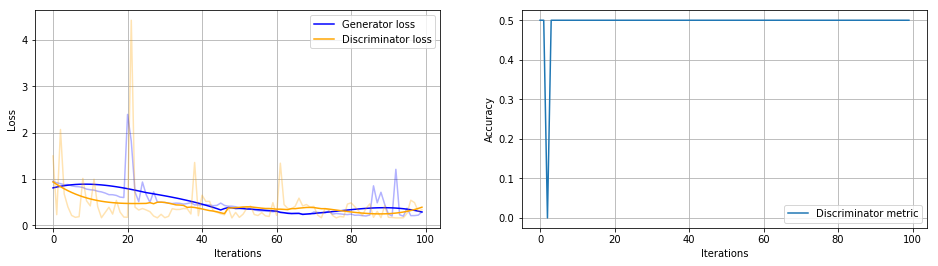

In [28]:
f = plt.figure(figsize=(16,4))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

g_labels = ["Generator loss"]+gan.combined.loss
#loop over gen loss components
#for curve in range(np.shape(gan.log["g_loss"])[-1]):
ax.plot(np.array(gan.log["g_loss"])[:,0] , alpha=0.3, c="b")
ax.plot(src.smooth(np.array(gan.log["g_loss"])[:,0]) ,label=g_labels[0], c="b")
ax.plot(gan.log["d_loss"], alpha=0.3, c="orange")
ax.plot(src.smooth(gan.log["d_loss"]),label="Discriminator loss", c="orange")
ax.grid()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
ax.legend(loc="best")

ax2.plot(gan.log["d_metric"],label="Discriminator metric")
ax2.grid()
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Accuracy")
ax2.legend(loc="best")

#plt.savefig("GAN_training")

______________________________________-
## Load datasets

__<font color='red'>SHOW</font>__

In [ ]:
gan_train, gan_truth, gan_val, gan_val_truth, gan_test, gan_test_truth = src.split_datasets(gan.train_data,
                                                                                             gan.xval_data,
                                                                                             gan.test_data,
                                                            past_frames=2, augment=gan.augment)

In [ ]:
gan.combined.save("test")
reloaded = load_model("test")
#log = np.load("log_Spatial_GAN_5000.npy").item()

In [ ]:
generator = gan.combined.layers[1]
discriminator = gan.combined.layers[2]

In [ ]:
predictions = generator.predict(gan_test)

In [ ]:
csi, far, pod = src.calculate_skill_scores(predictions, gan_test_truth, threshold=0.1)
print(np.mean(csi), np.mean(far), np.mean(pod))

In [ ]:
plt.imshow(gan_test[505,:,:,0])

In [ ]:
csi2, far2, pod2 = calculate_skill_scores(predictions, gan_test, threshold=0.1)
print(np.mean(csi2), np.mean(far2), np.mean(pod2))

In [ ]:
def calculate_skill_scores(ypredicted, ytruth, threshold=5):
    """
    Calculates some common weather forecasting metrics from these:
    hit: pred=truth=1, miss: pred=0 truth=1, false larm: pred=1 truth=0
    The metrics are: CSI: Critical Success Index, FAR: False Alarm Rate, POD: Probability od Detection
    :param ypredicted: shape (samples,w,h) predictions of network
    :param ytruth: shape (samles,w,h) same as for the predictions, ground truth next frame
    :param threshold: integer in 0.1mm. Below this means not raining, above this means raining.
    :return: csi, far, pod: lists of length sample_size. Metrics for each image.
    """
    binary_pred = np.zeros_like(ypredicted)
    binary_truth = np.zeros_like(ytruth)
    binary_pred[ypredicted >= threshold] = 1
    binary_truth[ytruth >= threshold] = 1
    # hits where the truth and prediction pixel falls to the same side of the threshold (both are 1)
    # (e.g. rains on truth and rains on prediction)
    # shape is (no. samples), each element is an int of matching pixels
    # pred = 1 and truth = 1
    hits = np.array([len(np.intersect1d(np.where(binary_pred[i].flatten()),
                         np.where(binary_truth[i].flatten()))) for i in range(len(binary_truth))])
    # pred = 0 and truth = 1
    misses = np.array([len(np.intersect1d(np.where(binary_pred[i].flatten() == 0),
                           np.where(binary_truth[i].flatten()))) for i in range(len(binary_truth))])
    # pred = 1 and truth = 0
    false_alarms = np.array([len(np.intersect1d(np.where(binary_pred[i].flatten()),
                                 np.where(binary_truth[i].flatten() == 0))) for i in range(len(binary_truth))])
    # critical success index
    print(np.argmin(hits+misses+false_alarms))
    csi = hits/(hits+misses+false_alarms)
    # false alarm rate
    far = false_alarms/(hits+false_alarms)
    # probability of detection
    pod = hits/(hits+misses)
    return csi, far, pod

In [ ]:
labels = discriminator.predict([predictions,gan_test])
labels

In [ ]:
plt.imshow(predictions[0,:,:,0])

In [ ]:
plt.imshow(gan_train[0,:,:,0])

In [ ]:
best = np.argmax(labels)
worst = np.argmin(labels)

In [ ]:
args = src.arg_getter(gan_test_truth, predictions)
args[-1]

In [ ]:
error_images, error_vals, error_means = src.error_distribution(gan_test_truth,predictions, metric="difference")

In [ ]:
%matplotlib inline
src.result_plotter(args[50:60], (gan_test[:,:,:,0], gan_test_truth[:,:,:,0], predictions[:,:,:,0], error_images[:,:,:,0]), save=False)

In [ ]:
#GAN learns:
#sharper but not more accurate
#small rain patches disappear
#learns an average wind motion: mostly to the right: applies that everywhere--> data augmentation based on optical flow
#hourly dataset with wind is still not accurate enough

In [ ]:
#train unet for 5min data, 1-1, 2-1, 3-1, best-more
#train a single disc gan for the 5min and the h data, 1-1, 2-1, 3-1, best-more
#train dual disc for hour data, 1-1, 2-1, 3-1, best-more

In [ ]:
#4 frames to predict one future frame, use that as input for further predictions

In [ ]:
test =gan_truth

In [ ]:
test.shape

In [ ]:
plt.subplot(4,4,2)
plt.imshow(augmented[0,:,:,0])
plt.axis("off")
plt.subplot(4,4,3)
plt.imshow(augmented[4,:,:,0])
plt.axis("off")
plt.subplot(4,4,8)
plt.imshow(augmented[1,:,:,0])
plt.axis("off")
plt.subplot(4,4,12)
plt.imshow(augmented[5,:,:,0])
plt.axis("off")
plt.subplot(4,4,14)
plt.imshow(augmented[2,:,:,0])
plt.axis("off")
plt.subplot(4,4,15)
plt.imshow(augmented[6,:,:,0])
plt.axis("off")
plt.subplot(4,4,5)
plt.imshow(augmented[3,:,:,0])
plt.axis("off")
plt.subplot(4,4,9)
plt.imshow(augmented[7,:,:,0])
plt.axis("off")
plt.savefig("augmentation")

In [ ]:
augmented = augment_data(test)

In [ ]:
augmented.shape

In [ ]:
def augment_data(data):
    #dimensions are n, h, w, c
    print("Data augmentig done.")
    return np.reshape([np.array([
        data_sample,
        rotate(data_sample, "90"),
        rotate(data_sample, "180"),
        rotate(data_sample, "270"),
        np.flip(data_sample, axis=1),
        np.flip(rotate(data_sample, "90"), axis=1),
        np.flip(rotate(data_sample, "180"), axis=1),
        np.flip(rotate(data_sample, "270"), axis=1)]) for data_sample in data], ((data.shape[0]*8,)+data.shape[1:]))

def rotate(img, degree):

    assert degree in ["90","-270", "180", "-90", "270"], "Rotation degree must be in: [90, 180, 270, -90, -270]"
    rotated = np.rot90(img)
    if degree in ["180", "-90", "270"]:
        rotated = np.rot90(rotated)
    if degree in ["-90", "270"]:
        rotated = np.rot90(rotated)
    return rotated